# MDPについて


## MDPの生成について

参考文献
* [Average-reward model-free reinforcement learning: a systematic review and literature mapping](https://arxiv.org/abs/2010.08920)
* [On the Generation of Markov Decision Processes](https://www.jstor.org/stable/2584329)
* [Natural Actor Critic Algorithms](https://hal.inria.fr/hal-00840470/document)

強化学習アルゴリズムの性能を比較したいとき、どんなMDPを使って評価するべきでしょうか？
適当にMDPを生成しても正しい評価にはなりません。
適当に生成したMDPが特定のアルゴリズムが得意なMDPになっていまう可能性は十分にあります。

### Garnet

MDPの適切な生成方法についての議論では[On the Generation of Markov Decision Processes](https://www.jstor.org/stable/2584329)がよく引用されます。
評価用のMDPを作る際は以下の要素を考慮するべきだとこの論文では議論されています：
1. 割引率 $\gamma$: どんなアルゴリズムでも割引率が小さいほど良い収束性を示します。
2. 最適性 $\varepsilon$: どんなアルゴリズムでも$\varepsilon$が小さいほど$\varepsilon$-最適な方策を見つけるために必要なコストが大きくなります。
3. 状態における選択可能な行動の数の平均と分散: 
4. 状態と行動における遷移可能な次状態の数: 一つの状態の情報を更新するコストは3と4によって決定されます。状態で選択可能な行動の数や次状態の数が多いほどコストが高いわけですね。
5. 状態の数 $|S|$: 状態の数が多い & 一つの状態におけるコストが大きい とき、状態ごとに並列化して情報を処理するメリットが大きくなります。
6. Mixingの早さ: どんな初期状態からスタートしても、別の$n$個の状態に行ってしまう確率が$n$にしたがって急激に高くなるとき、Mixingが早いと呼びます。早いMixingでは特定のアルゴリズム（Pre-Jacobiとか）の収束が早くなります。TODO [Dynamic Programming and Optimal Control](http://athenasc.com/dpbook.html)をよめ！
7. 遷移行列が下三角行列に集中しているか？: 集中している場合の状態の並びをweighted lower triangular (WLT)と呼びます。WLTのとき、特定のアルゴリズム (Gauss-Seidelとか)の収束が早くなります。 TODO [Dynamic Programming and Optimal Control](http://athenasc.com/dpbook.html)をよめ！
8. 非最適方策による遷移行列が最適方策のそれに近いか？: 
9. 非最適方策の価値が最適方策のそれに近いか？: 価値が似通っているとき、最適方策を見分けるのが難しくなります。つまり、最適方策に至るまでに必要なコストが高くなります。

[Garnet](https://hal.inria.fr/hal-00840470/document) (Generic Average Reward Non-stationary Environment Testbed)はこの性質をいい感じにランダム化して生成できるようなMDPです（らしい。ほんまか？）。
```"Garnet problems do not correspond to any particular application, but are meant to be totally abstract or generic while remaining representative of the kind of MDPs that might be encountered in practice."```
と良く言われています。

Garnetの生成についてはいろいろパターンがありますが、共通して重要なパラメータが以下のBranching factorです：
* $b$: それぞれの状態・行動について、遷移可能な次状態の数です。次状態は状態空間の中から重複なしでランダムに選択されます。遷移確率もランダムに選択されます。

In [2]:
import numpy as np
from functools import partial
from typing import Optional, NamedTuple
import jax.numpy as jnp

def create_rew_P(S: int, A: int, b: int):
    """ Garnet MDP (報酬関数, 遷移確率) を作成します

    Args:
        S (int): 状態空間のサイズ
        A (int): 行動空間のサイズ
        b (int): branching factor

    Returns:
        rew (float): 報酬関数
        P (float): 遷移確率
    """
    # ランダムな報酬関数を作ります
    rew = np.random.rand(S, A)

    # ランダムな遷移確率を作ります
    P = np.random.rand(S * A, S)

    for idx in range(S*A):
        unreachable_states = np.random.choice(S, size=S-b, replace=False)
        P[idx, unreachable_states] = 0
    P = P / np.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
    P = P.reshape(S, A, S)
    np.testing.assert_almost_equal(P.sum(axis=-1), 1)
    assert np.all(np.count_nonzero(P, axis=-1) == b)
    return jnp.array(rew), jnp.array(P)


class MDP(NamedTuple):
    S_array: np.array  # 状態空間
    A_array: np.array  # 行動空間
    gamma: float  # 割引率
    horizon: int  # ホライゾン
    rew: float  # 報酬関数
    P: float  # 遷移確率
    optimal_Q: Optional[np.ndarray] = None  # 最適Q値
    optimal_Q_idx: Optional[np.ndarray] = None  # 後でplot用に使います

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_array)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_array)


S = 50
A = 2
b = 2
S_array = np.arange(S)
A_array = np.arange(A)
gamma = 0.99
horizon = int(1 / (1 - gamma))

# Garnet MDPを作ります
t_rew, t_P = create_rew_P(S, A, b)
garnet_MDP = MDP(S_array, A_array, gamma, horizon, t_rew, t_P)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


GarnetMDPでValue Iterationを動かしてみましょう。

実験の前に、いくつか便利な関数を導入します。

1. ``compute_greedy_policy``: Q関数 ($S \times A \to \mathcal{R}$) の貪欲方策を返します
2. ``compute_optimal_Q``: MDPの最適Q関数 $q_* : S \times A \to \mathcal{R}$ を返します。
3. ``compute_policy_Q``: 方策 $\pi$ のQ関数 $q_\pi : S \times A \to \mathcal{R}$ を返します。
4. ``compute_optimality_gap``: 方策 $\pi$ と最適解との差 $\|q_* - q_{\pi}\|_\infty$ を返します。この値が小さいほど、$\pi$ はほぼ全ての状態行動対で最適な方策になっています。

In [6]:
from functools import partial
import jax


# >>>> 1 >>>>
@jax.jit
def compute_greedy_policy(Q: np.ndarray):
    greedy_policy = jnp.zeros_like(Q)
    S, A = Q.shape
    greedy_policy = greedy_policy.at[jnp.arange(S), Q.argmax(axis=1)].set(1)
    assert greedy_policy.shape == (S, A)
    return greedy_policy
# <<<< 1 <<<<


# >>>> 2 >>>>
@partial(jax.jit, static_argnames=("S", "A"))
def _compute_optimal_Q(mdp: MDP, S: int, A: int):

    def backup(optimal_Q):
        greedy_policy = compute_greedy_policy(optimal_Q)
        max_Q = (greedy_policy * optimal_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    optimal_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, optimal_Q)

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.S, mdp.A)
# <<<< 2 <<<<


# >>>> 3 >>>>
def compute_policy_Q(mdp: MDP, policy: np.ndarray):
    S, A = policy.shape

    def backup(policy_Q):
        max_Q = (policy * policy_Q).sum(axis=1)
        next_v = mdp.P @ max_Q
        assert next_v.shape == (S, A)
        return mdp.rew + mdp.gamma * next_v
    
    policy_Q = jnp.zeros((S, A))
    body_fn = lambda i, Q: backup(Q)
    return jax.lax.fori_loop(0, mdp.horizon + 1000, body_fn, policy_Q)
# <<<< 3 <<<<

# >>>> 4 >>>>
@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap
# <<<< 4 <<<<

garnet_MDP = garnet_MDP._replace(optimal_Q=compute_optimal_Q(garnet_MDP))

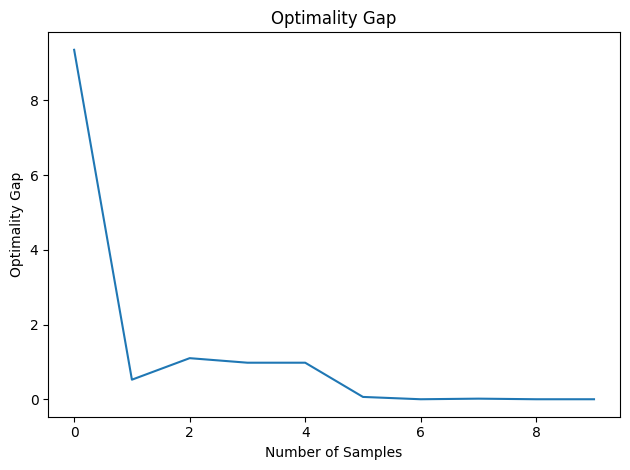

In [8]:
import matplotlib.pyplot as plt

@jax.jit
def compute_targ_Q(mdp: MDP, Q: np.ndarray):
    S, A = Q.shape
    greedy_policy = compute_greedy_policy(Q)
    max_Q = np.sum(greedy_policy * Q, axis=1).reshape(1, 1, S)
    next_v = np.sum(mdp.P * max_Q, axis=-1)
    assert next_v.shape == (S, A)
    return mdp.rew + mdp.gamma * next_v


def do_table_value_iteration(mdp: MDP, title):
    optimality_gaps = []
    
    # >>>> Do value iteration >>>>
    Q_table = np.zeros((mdp.S, mdp.A))
    for _ in range(10):
        Q_table = compute_targ_Q(mdp, Q_table)
        greedy_policy = compute_greedy_policy(Q_table)
        optimality_gaps.append(compute_optimality_gap(mdp, greedy_policy))
    # <<<< Do value iteration <<<<

    # >>>> Plot results >>>>
    plt.plot(optimality_gaps)
    plt.xlabel("Number of Samples")
    plt.ylabel("Optimality Gap")
    plt.title("Optimality Gap")
    # <<<< Plot results <<<<

    plt.tight_layout()

do_table_value_iteration(garnet_MDP, "GarnetMDP")